In [1]:
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import random

In [2]:
DISPLAY = True
SAVE = True
SIZE = (224, 224, 3)

In [3]:
def save_images_to_directory(image_list, directory_path):
    if not SAVE:
        return
    # Ensure the directory exists, and create it if it doesn't
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # Save the specified number of images from the list to the directory
    for i in range(len(image_list)):
        image = image_list[i]
        
        # Ensure that the image data is in uint8 format and that the shape is (height, width, channels)
        if image.dtype != np.uint8:
            image = (255 * image).astype(np.uint8)
        if len(image.shape) == 2:
            image = np.stack((image, image, image), axis=-1)

        image_pil = Image.fromarray(image)  # Convert to PIL Image
        image_pil.save(os.path.join(directory_path, f"image_{i:05d}.png"))

def apply_to(set, function, *param):
    new_set = []

    for s in set:
        new_set += function(s, *param)

    set += new_set

    return set

def display_images(image_list, maxx=1000):
    if not DISPLAY: 
        return
    """
    Display a list of images in a grid with automatically calculated rows and columns.

    Parameters:
    - image_list: List of images (numpy arrays) to display.

    Example:
    display_images([image1, image2, image3, image4, image5, image6, image7, image8, image9, image10])
    """
    num_images = len(image_list)
    if num_images > maxx:
        num_images = maxx
    side_length = int(math.ceil(math.sqrt(num_images)))  # Calculate the square root and round up

    rows = side_length
    columns = side_length

    # If the number of images is not a perfect square, adjust the number of rows and columns
    if rows * columns < num_images:
        rows = side_length
        columns = side_length + 1

    # Create a subplot grid with the calculated number of rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    for i in range(num_images):
        ax = axes[i // columns, i % columns]
        ax.imshow(image_list[i])
        ax.axis('off')  # Hide axis labels

    # Hide any remaining empty subplots
    for i in range(num_images, rows * columns):
        ax = axes[i // columns, i % columns]
        ax.axis('off')

    plt.show()

def load_images_from_directory(directory):
    image_list = []
    filenames = sorted(os.listdir(directory))
    for filename in filenames:
        image_path = os.path.join(directory, filename)
        image = Image.open(image_path)
        image_list.append(image)
    return image_list

In [24]:
directories = ['A/', 'B/', 'C/', 'D/', 'E/', 'F/']
path = "./Training/augmentation1/"

image_lists = []

for directory in directories:
    image_list = load_images_from_directory(path + directory)
    image_lists.append(image_list)

In [5]:
def blur_image(image, blur_factor=5):    
    return [cv2.GaussianBlur(image, (blur_factor, blur_factor), 0)]

In [16]:
def draw_line(image, thickness=2):
    height, width = image.shape[:2] 
    start = (np.random.randint(0, width), np.random.randint(0, height))
    end = (np.random.randint(0, width), np.random.randint(0, height))
    color = (0, 0, 0)
    return cv2.line(image.copy(), start, end, color, thickness)

In [7]:
def noise(image, brightness_factor=.5, saturation_factor=1, noise_factor=30):
    
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Adjust luminosity (brightness)
    hsv_image[:,:,2] = np.clip(hsv_image[:,:,2] + brightness_factor, 0, 255)

    # Adjust saturation
    hsv_image[:,:,1] = np.clip(hsv_image[:,:,1] * saturation_factor, 0, 255)

    # Convert back to BGR color space
    result_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    # Add some noise
    noise = np.random.normal(scale=noise_factor, size=result_image.shape)
    noisy_image = np.clip(result_image + noise, 0, 255).astype(np.uint8)

    return [noisy_image]

In [8]:
for image_list in image_lists:
    for i in range(len(image_list)):
        img_np = np.array(image_list[i])
        image_list[i] = Image.fromarray(cv2.resize(img_np, (224, 224)))

The goal of this second data augmentation is from one dataset i want to create 2 others so we end up with 3*original dataset:
- blurred images
- noisy images
- original images

for each images, I'd like to add randomly 0, 1, 2 or 3 lines on it to train the model on signs behind obstacles

In [19]:
def augment(ds:int):
    Orig = []
    Blur = []
    Nois = []
    for im in image_lists[ds]:
        Orig.append(blur_image(np.array(im), 27)[0])
        Blur.append(np.array(im))
        Nois.append(noise(np.array(im))[0])

    res = []
    for i in Orig:
        res.append(i)

    for i in Blur:
        res.append(i)

    for i in Nois:
        res.append(i)

    # Add lines
        
    for i in range(len(res)):

        x = random.random()
        
        if x < .4:
            continue
        elif x < .7:
            # draw 1 line
            res[i] = draw_line(res[i], thickness=20)
        elif x < .9:
            # draw 2 lines
            tmp = draw_line(res[i], thickness=15)
            res[i] = draw_line(tmp, thickness=15)
        else:
            # draw 3 lines
            tmp = draw_line(res[i], thickness=10)
            tmp = draw_line(tmp, thickness=10)
            res[i] = draw_line(tmp, thickness=10)

            
    return res


In [22]:
A = augment(0)
B = augment(1)
C = augment(2)
D = augment(3)
E = augment(4)
F = augment(5)

576


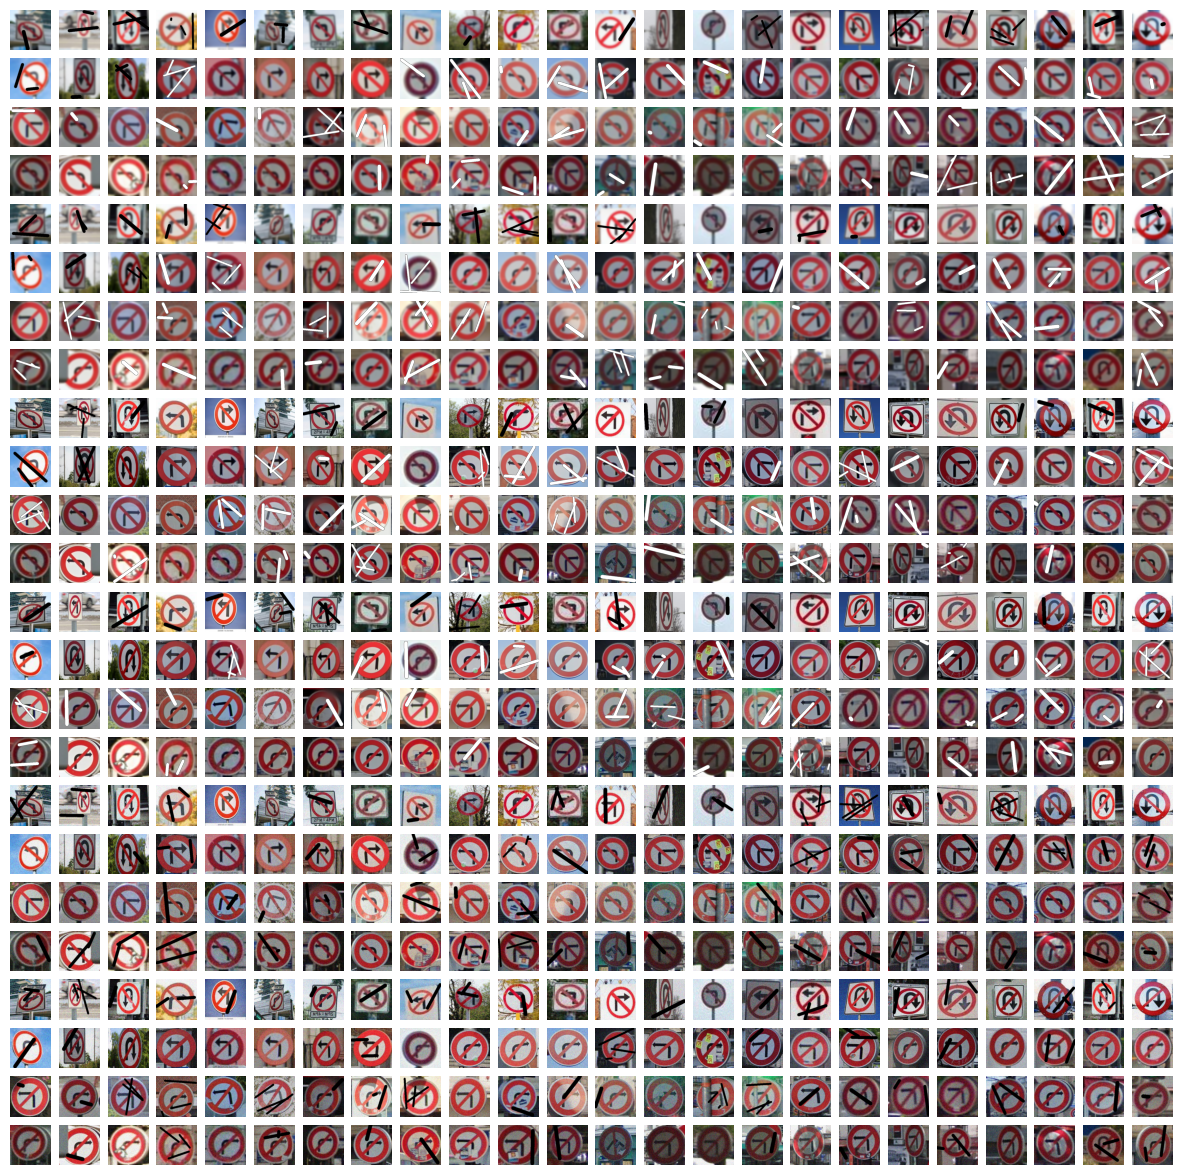

In [21]:
print(len(O))

display_images(O)

In [25]:
save_images_to_directory(A, './Training/augmentation2/A/')
save_images_to_directory(B, './Training/augmentation2/B/')
save_images_to_directory(C, './Training/augmentation2/C/')
save_images_to_directory(D, './Training/augmentation2/D/')
save_images_to_directory(E, './Training/augmentation2/E/')
save_images_to_directory(F, './Training/augmentation2/F/')